In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Forest Cover Type (Multiclass classification)

# Imports


In [ ]:
# Core Libraries
import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt
import seaborn as sns

# Sklearn Preprocessing & Selection
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn.preprocessing import StandardScaler

# Sklearn Models
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier

# Sklearn Metrics
from sklearn.metrics import (
    classification_report,
    accuracy_score,
    f1_score,
    confusion_matrix
)

# Loading Dataset

In [ ]:
train = pd.read_csv('/content/drive/MyDrive/AIT511 Course Project/covtype.csv')
train.head()

,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horizontal_Distance_To_Fire_Points,...,Soil_Type32,Soil_Type33,Soil_Type34,Soil_Type35,Soil_Type36,Soil_Type37,Soil_Type38,Soil_Type39,Soil_Type40,Cover_Type
0,2596,51,3,258,0,510,221,232,148,6279,...,0,0,0,0,0,0,0,0,0,5
1,2590,56,2,212,-6,390,220,235,151,6225,...,0,0,0,0,0,0,0,0,0,5
2,2804,139,9,268,65,3180,234,238,135,6121,...,0,0,0,0,0,0,0,0,0,2
3,2785,155,18,242,118,3090,238,238,122,6211,...,0,0,0,0,0,0,0,0,0,2
4,2595,45,2,153,-1,391,220,234,150,6172,...,0,0,0,0,0,0,0,0,0,5


In [ ]:
train.shape

(581012, 55)

# EDA

In [ ]:
# Set Style
sns.set_style("whitegrid")

In [ ]:
print("\n--- Step 1: Data Quality Check ---")
# Check for missing values
missing_values = train.isnull().sum().sum()
print(f"Total Missing Values: {missing_values}")


--- Step 1: Data Quality Check ---
Total Missing Values: 0


In [ ]:
# Check for duplicates
duplicates = train.duplicated().sum()
print(f"Total Duplicates: {duplicates}")

Total Duplicates: 0


/tmp/ipython-input-1322735244.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='Cover_Type', data=train, palette='viridis')


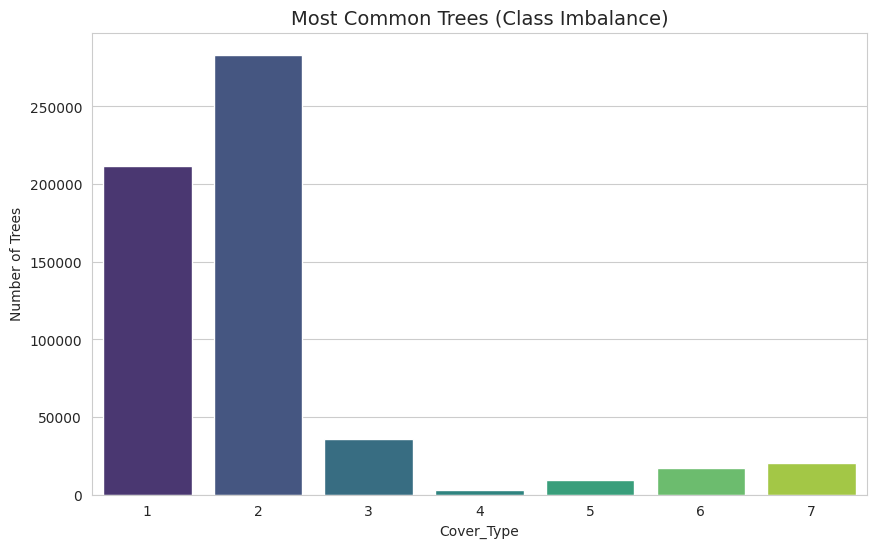

In [ ]:
# 1. Common Trees (Target Distribution)
plt.figure(figsize=(10, 6))
sns.countplot(x='Cover_Type', data=train, palette='viridis')
plt.title("Most Common Trees (Class Imbalance)", fontsize=14)
plt.ylabel("Number of Trees")
plt.show()

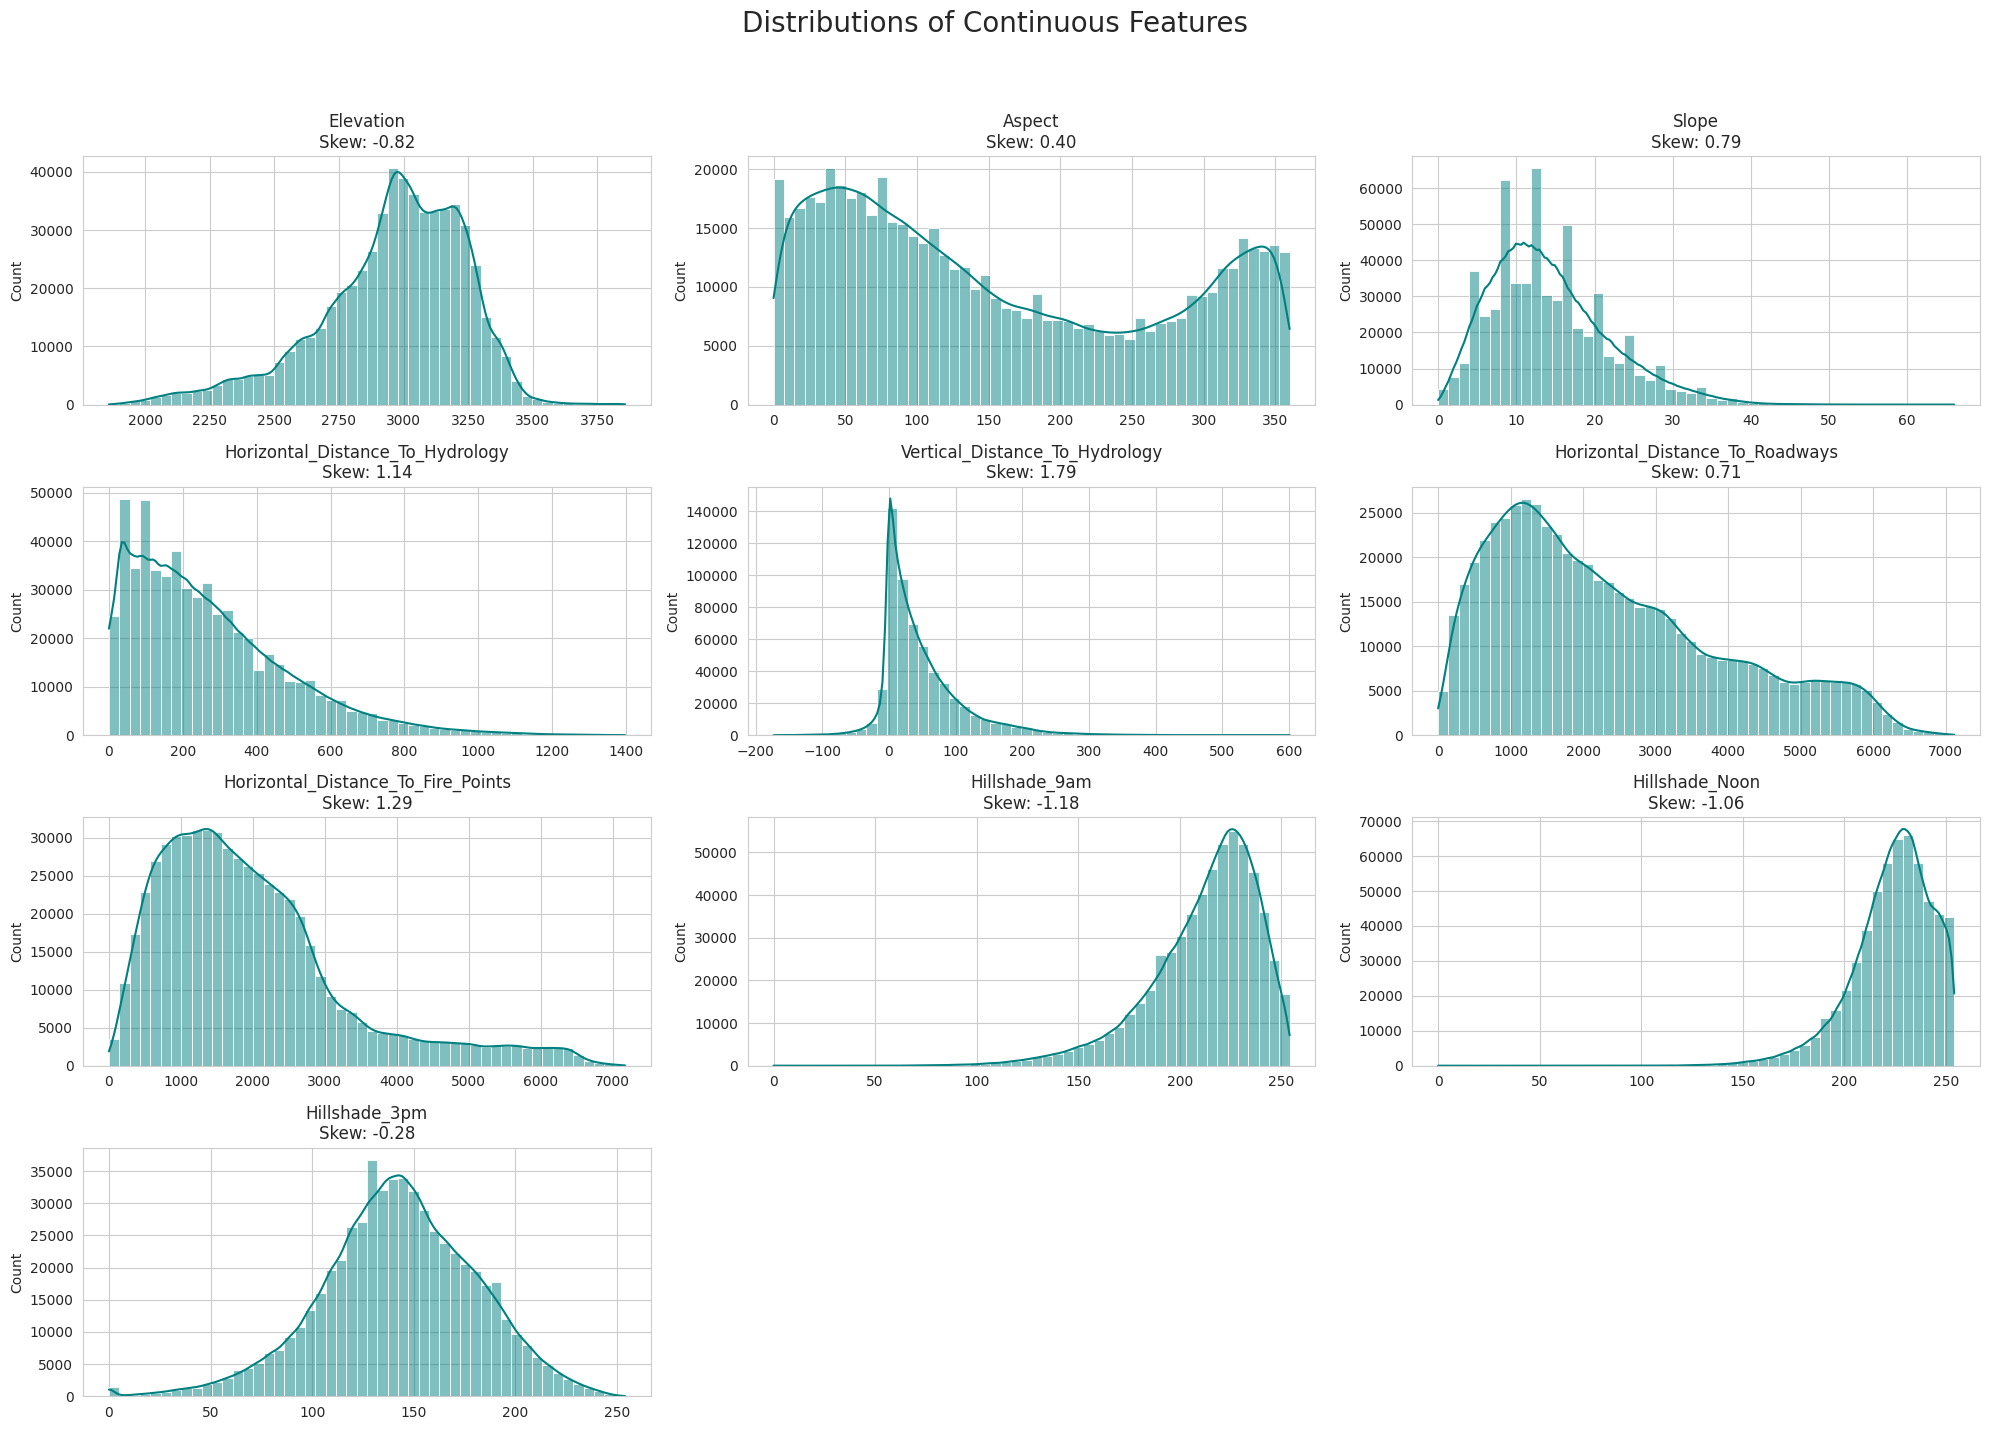


--- Skewness Statistics ---
Vertical_Distance_To_Hydrology        1.790250
Horizontal_Distance_To_Fire_Points    1.288644
Horizontal_Distance_To_Hydrology      1.140437
Slope                                 0.789273
Horizontal_Distance_To_Roadways       0.713679
Aspect                                0.402628
Hillshade_3pm                        -0.277053
Elevation                            -0.817596
Hillshade_Noon                       -1.063056
Hillshade_9am                        -1.181147
dtype: float64
- Skew > 1 or < -1: Highly Skewed (Needs Log Transformation)
- Skew between -0.5 and 0.5: Approximately Symmetric (Good for Normal Distribution)


In [ ]:
# 2. Histograms
# Define Continuous Features
# These are the columns where distribution matters (not binary 0/1 columns)
continuous_cols = [
    'Elevation', 'Aspect', 'Slope',
    'Horizontal_Distance_To_Hydrology', 'Vertical_Distance_To_Hydrology',
    'Horizontal_Distance_To_Roadways', 'Horizontal_Distance_To_Fire_Points',
    'Hillshade_9am', 'Hillshade_Noon', 'Hillshade_3pm'
]

# Plot Histograms
plt.figure(figsize=(20, 15))
plt.suptitle("Distributions of Continuous Features", fontsize=20)

for i, col in enumerate(continuous_cols):
    plt.subplot(4, 3, i+1) # 4 rows, 3 columns
    sns.histplot(train[col], kde=True, bins=50, color='teal')
    plt.title(f"{col}\nSkew: {train[col].skew():.2f}")
    plt.xlabel("") # Hide x-label to save space

plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # Adjust layout to make room for suptitle
plt.show()

# Skewness Summary
print("\n--- Skewness Statistics ---")
skew_vals = train[continuous_cols].skew().sort_values(ascending=False)
print(skew_vals)
print("- Skew > 1 or < -1: Highly Skewed (Needs Log Transformation)")
print("- Skew between -0.5 and 0.5: Approximately Symmetric (Good for Normal Distribution)")

/tmp/ipython-input-1126350073.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Cover_Type', y='Elevation', data=train, palette='coolwarm')


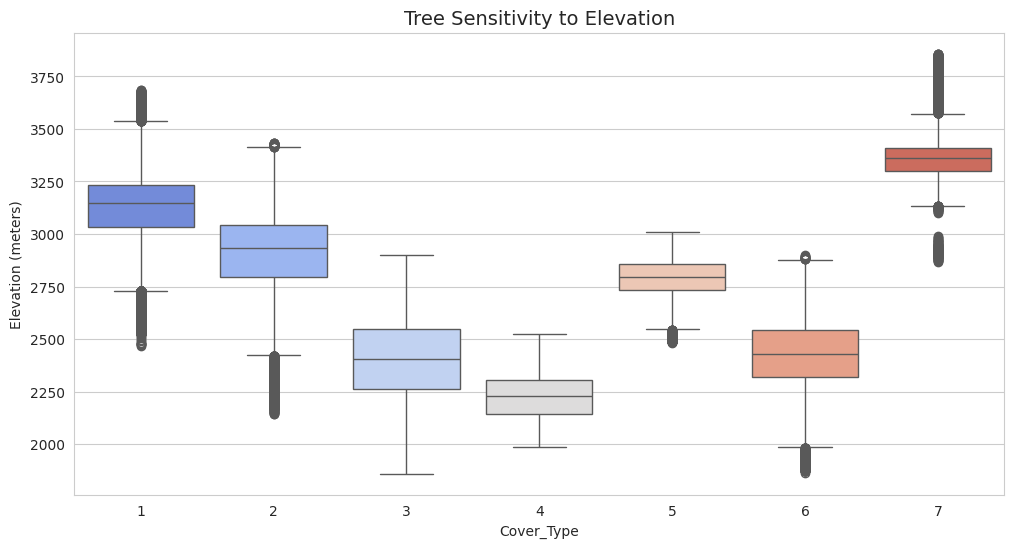

In [ ]:
# 3. Sensitivity Analysis (Elevation)
plt.figure(figsize=(12, 6))
sns.boxplot(x='Cover_Type', y='Elevation', data=train, palette='coolwarm')
plt.title("Tree Sensitivity to Elevation", fontsize=14)
plt.ylabel("Elevation (meters)")
plt.show()

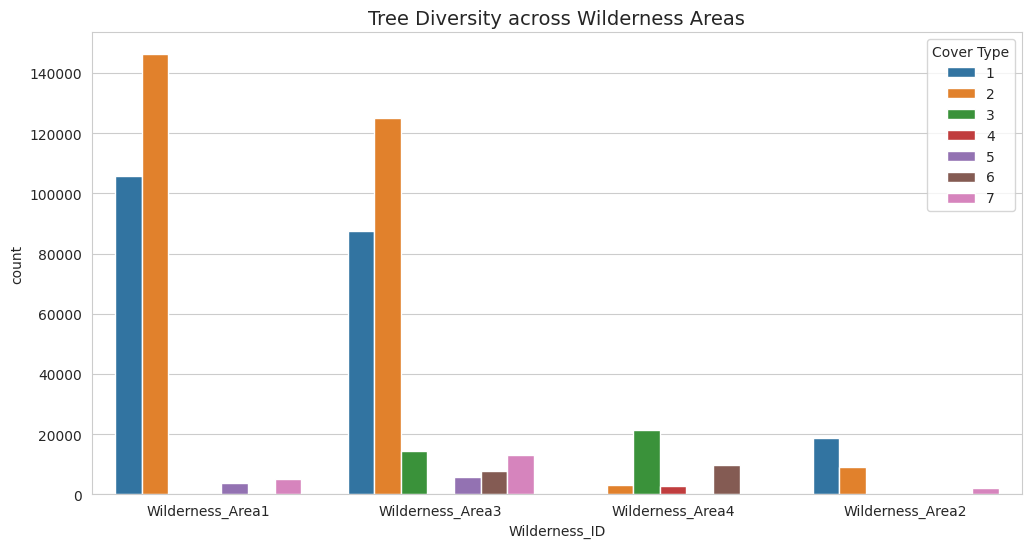

In [ ]:
# 4. Wilderness Area Diversity
# Reconstruct Wilderness Area column from one-hot encoding
wild_cols = ['Wilderness_Area1', 'Wilderness_Area2', 'Wilderness_Area3', 'Wilderness_Area4']
train['Wilderness_ID'] = train[wild_cols].idxmax(axis=1)

plt.figure(figsize=(12, 6))
sns.countplot(x='Wilderness_ID', hue='Cover_Type', data=train, palette='tab10')
plt.title("Tree Diversity across Wilderness Areas", fontsize=14)
plt.legend(title='Cover Type', loc='upper right')
plt.show()

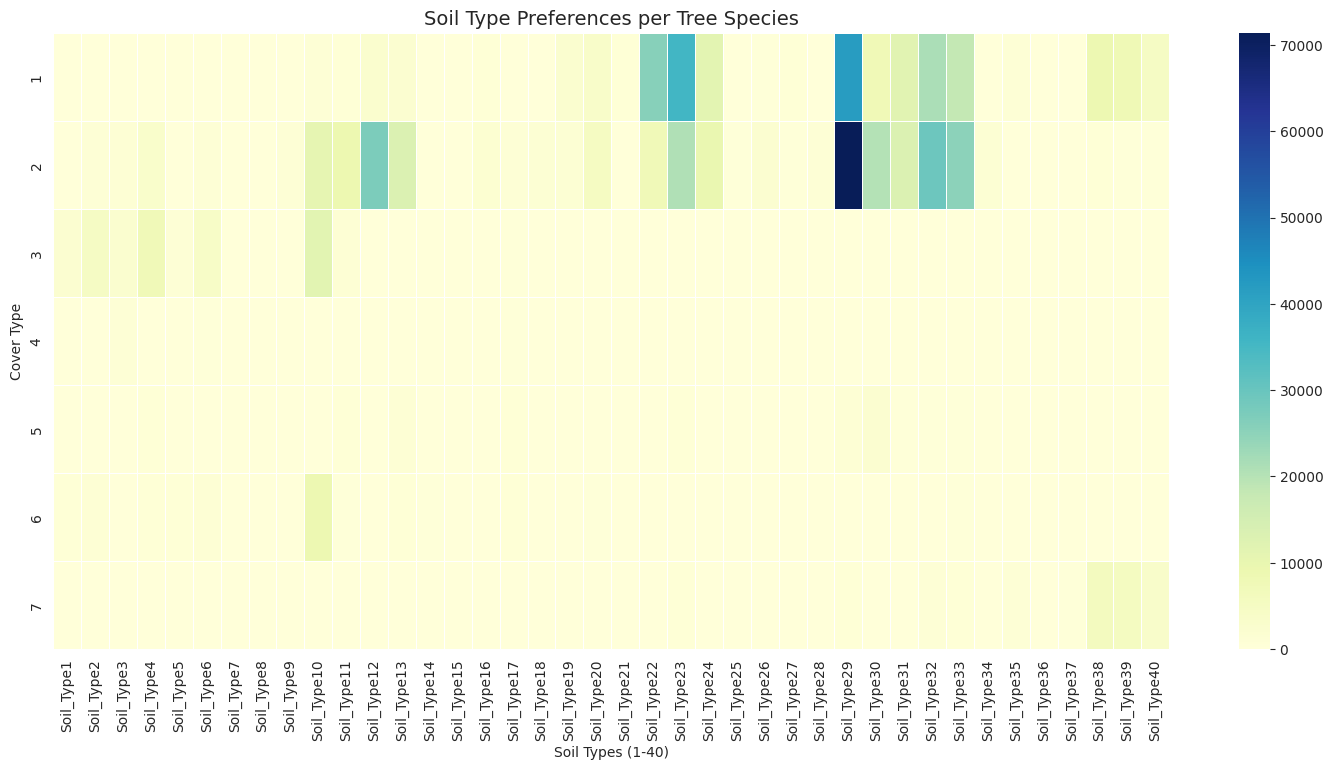

In [ ]:
# 5. Soil Type Heatmap
# Summing soil types per cover type to see preferences
soil_cols = [col for col in train.columns if 'Soil_Type' in col]
soil_counts = train.groupby('Cover_Type')[soil_cols].sum()

plt.figure(figsize=(18, 8))
sns.heatmap(soil_counts, cmap='YlGnBu', linewidths=0.5)
plt.title("Soil Type Preferences per Tree Species", fontsize=14)
plt.xlabel("Soil Types (1-40)")
plt.ylabel("Cover Type")
plt.show()

In [ ]:
# Print specific insights
print("Top 3 Soil Types per Tree Class:")
for i in range(1, 8):
    if i in soil_counts.index:
        top_3 = soil_counts.loc[i].sort_values(ascending=False).head(3).index.tolist()
        print(f"  Type {i}: {top_3}")

Top 3 Soil Types per Tree Class:
  Type 1: ['Soil_Type29', 'Soil_Type23', 'Soil_Type22']
  Type 2: ['Soil_Type29', 'Soil_Type32', 'Soil_Type12']
  Type 3: ['Soil_Type10', 'Soil_Type4', 'Soil_Type2']
  Type 4: ['Soil_Type3', 'Soil_Type17', 'Soil_Type6']
  Type 5: ['Soil_Type30', 'Soil_Type13', 'Soil_Type29']
  Type 6: ['Soil_Type10', 'Soil_Type6', 'Soil_Type2']
  Type 7: ['Soil_Type38', 'Soil_Type39', 'Soil_Type40']


# Feature Engineering & Data Transformation

In [ ]:
# 1. Feature Transformations (Fixing Skewness & Circularity)
# -------------------------------------------------------
print("Applying Transformations...")

# A. Log Transformation for Skewed Features
# We saw these had long tails in the histograms. Log-transform makes them normal-like.
skewed_cols = ['Horizontal_Distance_To_Hydrology',
               'Horizontal_Distance_To_Fire_Points',
               'Horizontal_Distance_To_Roadways']

for col in skewed_cols:
    # Use log1p (log(x+1)) to handle zeros safely
    train[col] = np.log1p(train[col])

Applying Transformations...


In [ ]:
# B. Circular Encoding for Aspect
# Aspect is 0-360 degrees. We convert to Sin/Cos to preserve directionality.
train['Aspect_Sin'] = np.sin(np.radians(train['Aspect']))
train['Aspect_Cos'] = np.cos(np.radians(train['Aspect']))
train = train.drop('Aspect', axis=1) # Drop original to avoid redundancy

In [ ]:
# 3. Feature Engineering (Creating New Insights)
# -------------------------------------------------------
print("Creating Interaction Features...")

# C. Euclidean Distance to Hydrology
# The dataset gives horizontal and vertical distance separately.
# Real distance is the hypotenuse: sqrt(h^2 + v^2)
# Note: We use the raw values for calculation logic, but since we logged the
# horizontal distance in step A, we should be careful.
# For simplicity in this project, we will approximate using the transformed values
# or just creating a new interaction based on the original logic.
# Let's create a simple linear combination which acts as a proxy for "Total Distance"
train['Hydrology_Total_Dist'] = train['Horizontal_Distance_To_Hydrology'] + abs(train['Vertical_Distance_To_Hydrology'])

# D. Elevation relative to Water
# Trees often depend on how high they are ABOVE the water source.
train['Elevation_Diff_Hydro'] = train['Elevation'] - train['Vertical_Distance_To_Hydrology']

# E. Sunlight Index (Hillshade Mean)
# Average of morning, noon, and afternoon shade gives general solar exposure.
train['Mean_Hillshade'] = (train['Hillshade_9am'] + train['Hillshade_Noon'] + train['Hillshade_3pm']) / 3

# E. Amenity Proximity
# Average distance to human-made features (Roads & Fire Points)
train['Mean_Dist_Amenities'] = (train['Horizontal_Distance_To_Fire_Points'] + train['Horizontal_Distance_To_Roadways']) / 2

Creating Interaction Features...


In [ ]:
if 'Wilderness_ID' in train.columns:
    train.drop('Wilderness_ID', axis=1, inplace=True)
    print("Column dropped")

Column dropped


In [ ]:
# 4. Scaling (StandardScaler)
# -------------------------------------------------------
# Separate Target
X = train.drop('Cover_Type', axis=1)
y = train['Cover_Type']

In [ ]:
# Identify Continuous Columns to Scale
# We exclude the binary columns (Wilderness_AreaX and Soil_TypeX)
# Logic: If max value > 1, it's continuous.
continuous_cols = [col for col in X.columns if X[col].max() > 1]

# Add our new Sin/Cos features (they are -1 to 1, but scaling helps standardize variance)
continuous_cols += ['Aspect_Sin', 'Aspect_Cos']
continuous_cols = list(set(continuous_cols)) # Remove duplicates

print(f"Scaling {len(continuous_cols)} continuous features...")

scaler = StandardScaler()
X[continuous_cols] = scaler.fit_transform(X[continuous_cols])

Scaling 15 continuous features...


In [ ]:
# 5. Stratified Split
# -------------------------------------------------------
# We use 'stratify=y' to ensure the rare classes (Type 4) are split evenly.
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

In [ ]:
print(f"Training Shape: {X_train.shape}")
print(f"Test Shape: {X_test.shape}")

Training Shape: (464809, 59)
Test Shape: (116203, 59)


# Model Training

In [ ]:
# 1. Setup Tuning Data (CRITICAL STEP)
# -------------------------------------------------------
# SVM and Neural Networks are too slow to tune on 500k rows.
# We take a stratified sample (e.g., 10% or max 15k samples) just for finding parameters.


# Subsample for tuning (using 15,000 samples is a safe sweet spot for Colab)
X_tune, _, y_tune, _ = train_test_split(
    X_train, y_train, train_size=15000, stratify=y_train, random_state=42
)

print(f"Original Train Size: {X_train.shape}")
print(f"Tuning Subset Size:  {X_tune.shape} (Used for RandomizedSearch)")

Original Train Size: (464809, 59)
Tuning Subset Size:  (15000, 59) (Used for RandomizedSearch)


# ML Models Used

In [ ]:
# 2. Define Models & Parameter Grids
# -------------------------------------------------------

# --- Model A: Logistic Regression ---
# Fast, interpretable baseline
lr_params = {
    'C': [0.1, 1, 10],
    'solver': ['saga'], # 'saga' is faster for large multiclass datasets
    'multi_class': ['multinomial'],
    'max_iter': [500]
}

# --- Model B: Support Vector Machine (SVM) ---
# Powerful but computationally expensive
svm_params = {
    'C': [1, 10, 100],
    'kernel': ['rbf'], # RBF is usually best for nature data
    'gamma': ['scale', 0.1, 0.01]
}

# --- Model C: Neural Network (MLP) ---
# Captures complex non-linear patterns
mlp_params = {
    'hidden_layer_sizes': [(64, 32), (100, 50), (128, 64, 32)],
    'activation': ['relu', 'tanh'],
    'alpha': [0.0001, 0.001], # L2 Regularization
    'learning_rate_init': [0.001, 0.01]
}

# Hyperparameter tuning using RandomizedSearchCV

In [ ]:
# 3. Tuning Loop (Using RandomizedSearchCV)
# -------------------------------------------------------
# We use RandomizedSearchCV because it's much faster than GridSearchCV
# and usually finds equally good parameters.

model_configs = [
    ("Logistic Regression", LogisticRegression(random_state=42), lr_params),
    ("SVM", SVC(random_state=42), svm_params),
    ("Neural Network", MLPClassifier(max_iter=300, random_state=42), mlp_params)
]

best_estimators = {}

print("\nStarting Hyperparameter Tuning (on subset)...")

for name, model, params in model_configs:
    print(f"\n--- Tuning {name} ---")
    start_time = time.time()

    # n_iter=5 means it tries 5 random combinations.
    # Increase to 10-20 if you have more time.
    search = RandomizedSearchCV(
        model, params, n_iter=5, cv=3, scoring='f1_macro',
        n_jobs=-1, random_state=42, verbose=1
    )

    search.fit(X_tune, y_tune)

    elapsed = time.time() - start_time
    print(f"Done in {elapsed:.1f} seconds.")
    print(f"Best Params: {search.best_params_}")
    print(f"Best CV F1-Score: {search.best_score_:.4f}")

    # Store the best model configuration
    best_estimators[name] = search.best_estimator_


Starting Hyperparameter Tuning (on subset)...

--- Tuning Logistic Regression ---
Fitting 3 folds for each of 3 candidates, totalling 9 fits


/usr/local/lib/python3.12/dist-packages/sklearn/model_selection/_search.py:317: UserWarning: The total space of parameters 3 is smaller than n_iter=5. Running 3 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Done in 121.9 seconds.
Best Params: {'solver': 'saga', 'multi_class': 'multinomial', 'max_iter': 500, 'C': 10}
Best CV F1-Score: 0.5570

--- Tuning SVM ---
Fitting 3 folds for each of 5 candidates, totalling 15 fits
Done in 183.8 seconds.
Best Params: {'kernel': 'rbf', 'gamma': 0.1, 'C': 100}
Best CV F1-Score: 0.6924

--- Tuning Neural Network ---
Fitting 3 folds for each of 5 candidates, totalling 15 fits
Done in 619.6 seconds.
Best Params: {'learning_rate_init': 0.001, 'hidden_layer_sizes': (128, 64, 32), 'alpha': 0.0001, 'activation': 'tanh'}
Best CV F1-Score: 0.6818


# Training on Full Dataset

In [ ]:
# 4. Final Training (On FULL Dataset)
# -------------------------------------------------------
print("\nRetraining Best Models on FULL Dataset (580k rows)...")
# Note: SVM might still be too slow on full data.
# If SVM takes > 30 mins, stop it and rely on the subset result or use a larger subset (e.g. 50k).

final_results = {}

for name, model in best_estimators.items():
    print(f"\nTraining Final {name}...")

    # SPECIAL HANDLING FOR SVM ON COLAB
    if name == "SVM" and X_train.shape[0] > 50000:
        print("SVM is too slow for 580k rows.")
        print("   -> Training on a larger subset (50,000 rows) instead of full data to prevent crash.")
        # Create a larger subset specifically for SVM final training
        X_svm, _, y_svm, _ = train_test_split(X_train, y_train, train_size=50000, stratify=y_train, random_state=42)
        model.fit(X_svm, y_svm)
    else:
        # Logistic Regression & Neural Net can handle the full size
        model.fit(X_train, y_train)

    # Evaluation
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='macro')

    final_results[name] = {'Accuracy': acc, 'F1-Macro': f1}

    print(f"--- {name} Results ---")
    print(f"Accuracy: {acc:.4f}")
    print(f"Macro F1: {f1:.4f}")
    print(classification_report(y_test, y_pred))


Retraining Best Models on FULL Dataset (580k rows)...

Training Final Logistic Regression...


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


--- Logistic Regression Results ---
Accuracy: 0.7218
Macro F1: 0.5537
              precision    recall  f1-score   support

           1       0.71      0.69      0.70     42368
           2       0.74      0.80      0.77     56661
           3       0.69      0.80      0.74      7151
           4       0.66      0.53      0.59       549
           5       0.47      0.04      0.08      1899
           6       0.50      0.29      0.37      3473
           7       0.73      0.56      0.63      4102

    accuracy                           0.72    116203
   macro avg       0.64      0.53      0.55    116203
weighted avg       0.71      0.72      0.71    116203


Training Final SVM...
SVM is too slow for 580k rows.
   -> Training on a larger subset (50,000 rows) instead of full data to prevent crash.
--- SVM Results ---
Accuracy: 0.8615
Macro F1: 0.8131
              precision    recall  f1-score   support

           1       0.87      0.83      0.85     42368
           2       0.86      

In [ ]:
# 5. Comparison
print("\nFinal Comparison Summary:")
for name, metrics in final_results.items():
    print(f"{name}: Accuracy={metrics['Accuracy']:.4f}, F1-Macro={metrics['F1-Macro']:.4f}")


Final Comparison Summary:
Logistic Regression: Accuracy=0.7218, F1-Macro=0.5537
SVM: Accuracy=0.8615, F1-Macro=0.8131
Neural Network: Accuracy=0.9424, F1-Macro=0.9070


# Comparison between the trained models

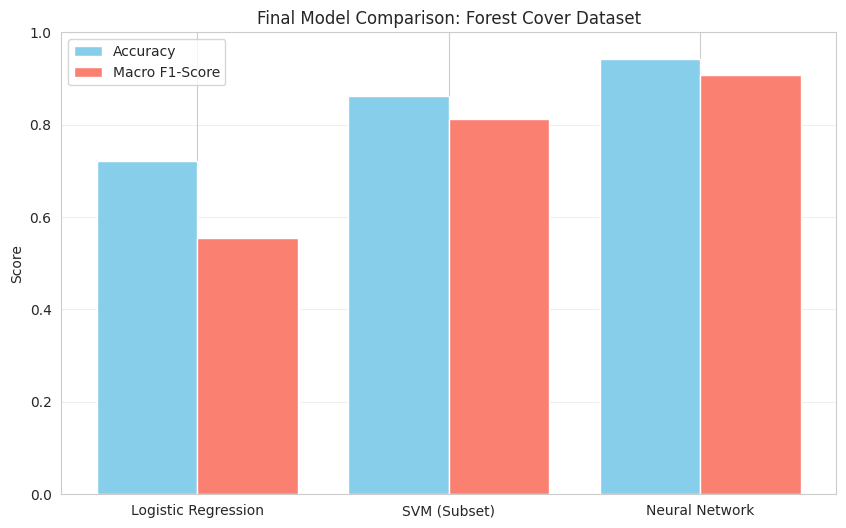

In [ ]:
# Your actual results
models = ['Logistic Regression', 'SVM (Subset)', 'Neural Network']
accuracies = [0.7218, 0.8615, 0.9424]
f1_scores = [0.5537, 0.8131, 0.9070]

x = range(len(models))

plt.figure(figsize=(10, 6))
plt.bar([i - 0.2 for i in x], accuracies, width=0.4, label='Accuracy', color='skyblue')
plt.bar([i + 0.2 for i in x], f1_scores, width=0.4, label='Macro F1-Score', color='salmon')

plt.xticks(x, models)
plt.ylim(0, 1.0)
plt.title("Final Model Comparison: Forest Cover Dataset")
plt.ylabel("Score")
plt.legend()
plt.grid(axis='y', alpha=0.3)
plt.show()